In [118]:
import pandas as pd

# 파일 경로들 정리
file_paths = {
    "streetlight": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구 가로등 위치 정보.csv",
    "senior_leisure": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구 사회복지시설(노인여가복지시설).csv",
    "senior_job": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구 사회복지시설(노인일자리지원기관).csv",
    "senior_homecare": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구 사회복지시설(재가노인복지시설).csv",
    "cctv": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_CCTV.csv",
    "intersection": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_교차로_위치찐.csv",
    "bus_stop": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_버스정류소.csv",
    "hospital": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_병의원.csv",
    "market": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_전통시장.csv",
    "subway": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_지하철역.csv",
    "crosswalk": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_횡단보도_중심좌표.csv",

}

# 안전한 CSV 로딩 함수 (인코딩 자동 처리)
def load_csv_safely(path):
    for enc in ['utf-8', 'cp949', 'euc-kr']:
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    raise ValueError(f"인코딩 문제로 파일을 불러올 수 없습니다: {path}")

# 모든 데이터프레임 불러오기
dataframes = {name: load_csv_safely(path) for name, path in file_paths.items()}

# 각각 개별 변수로도 저장 가능 (선택사항)
streetlight      = dataframes["streetlight"]
senior_leisure   = dataframes["senior_leisure"]
senior_job       = dataframes["senior_job"]
senior_homecare  = dataframes["senior_homecare"]
cctv             = dataframes["cctv"]
intersection     = dataframes["intersection"]
bus_stop         = dataframes["bus_stop"]
hospital         = dataframes["hospital"]
market           = dataframes["market"]
subway           = dataframes["subway"]
crosswalk        = dataframes["crosswalk"]


# 확인용 출력
for name, df in dataframes.items():
    print(f"{name}: {df.shape} rows")
    print(df.columns.tolist())
    print()


streetlight: (495, 4) rows
['관리번호', '위도', '경도', 'geometry']

senior_leisure: (5, 12) rows
['시설명', '시설코드', '시설종류명(시설유형)', '시설종류상세명(시설종류)', '자치구(시)구분', '시군구코드', '시군구명', '시설주소', '전화번호', '우편번호', '위도', '경도']

senior_job: (1, 12) rows
['시설명', '시설코드', '시설종류명(시설유형)', '시설종류상세명(시설종류)', '자치구(시)구분', '시군구코드', '시군구명', '시설주소', '전화번호', '우편번호', '위도', '경도']

senior_homecare: (83, 12) rows
['시설명', '시설코드', '시설종류명(시설유형)', '시설종류상세명(시설종류)', '자치구(시)구분', '시군구코드', '시군구명', '시설주소', '전화번호', '우편번호', '위도', '경도']

cctv: (2628, 12) rows
['NO', 'ATNRG_NM', 'SAFETY_ADDR', 'CCTV_USE', 'LA', 'LO', 'CCTV_QTY', 'UPDATE_DT', 'PLCST_NM', 'PLCST_DEPT_NM', 'PLCST_DEPT_CD', 'CTPR_PLAGC_NM']

intersection: (285, 28) rows
['교차로코드', '입력일자', '교차로명칭', '유형코드', '연동교차로코드', '구코드 (공통);', '지번', '구경찰서 (공통);', '신경찰서 (공통);', '작업구분 (공통);', '표출구분 (공통);', '고객번호', '계약종별', '계량기번호', '도로구분 (공통);', '관할사업소 (공통);', '교차로관리번호', '공간데이터', '신규정규화ID', '이력ID', '동코드 (공통);', '공사형태 (공통);', '지도표출구분', 'X좌표', 'Y좌표', '경도', '위도', 'geometry']

bus_stop: (316, 7) rows


## 보행등

In [128]:
walklight = pd.read_csv("C:/Users/윤홍식/Downloads/서울특별시_보행등 위치좌표 현황_20221223.csv",encoding='euc-kr')

In [132]:
walklight_ddm = walklight[walklight['자치구'] == '동대문구']


✅ 저장 완료: walklight.asc


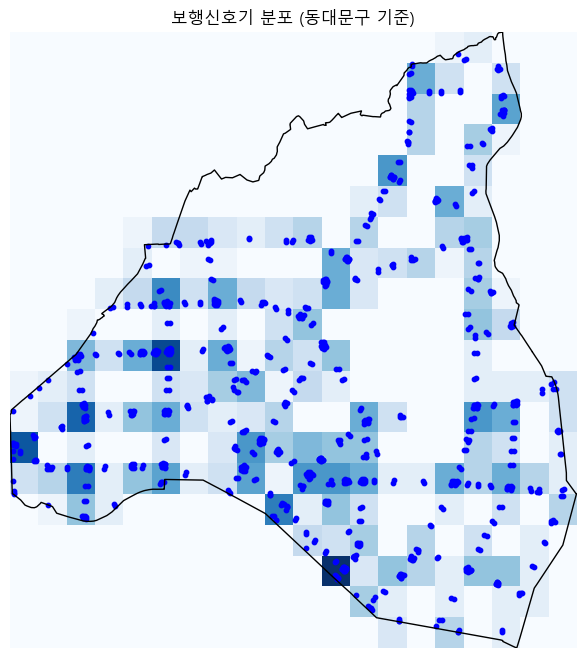

In [136]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 🔹 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 🔹 동대문구 shp 불러오기
shp_path = "C:/Users/윤홍식/Downloads/sig_20230729/sig.shp"
gdf = gpd.read_file(shp_path)
dongdaemun = gdf[gdf["SIG_ENG_NM"] == "Dongdaemun-gu"]
dongdaemun = dongdaemun.set_crs(epsg=5179, allow_override=True)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 🔹 walklight 데이터: 동대문구만 필터링된 DataFrame을 사용
# 예시: walklight_ddm = walklight[walklight["자치구"] == "동대문구"]
# 이미 walklight_ddm이 준비되어 있다고 가정

# 🔹 walklight 포인트 → GeoDataFrame (EPSG:5186)
walklight_gdf = gpd.GeoDataFrame(
    walklight_ddm,
    geometry=gpd.points_from_xy(walklight_ddm["X좌표"], walklight_ddm["Y좌표"]),
    crs="EPSG:5186"
)

# 🔹 동대문구 경계로 클리핑
walklight_clipped = gpd.clip(walklight_gdf, dongdaemun_proj)
walklight_proj = walklight_clipped  # 이미 EPSG:5186

# 🔹 래스터 그리드 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 🔹 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 🔹 walklight 포인트 → 셀 카운트 누적
for point in walklight_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1

# 🔹 asc 저장
with rasterio.open(
    "walklight.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: walklight.asc")

# 🔹 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Blues', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
walklight_proj.plot(ax=plt.gca(), color='blue', markersize=10)
plt.title("보행신호기 분포 (동대문구 기준)")
plt.axis('off')
plt.show()


## senior_leisure

In [10]:
senior_leisure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   시설명            5 non-null      object 
 1   시설코드           5 non-null      object 
 2   시설종류명(시설유형)    5 non-null      object 
 3   시설종류상세명(시설종류)  5 non-null      object 
 4   자치구(시)구분       5 non-null      object 
 5   시군구코드          5 non-null      int64  
 6   시군구명           5 non-null      object 
 7   시설주소           5 non-null      object 
 8   전화번호           0 non-null      float64
 9   우편번호           0 non-null      float64
 10  위도             5 non-null      float64
 11  경도             5 non-null      float64
dtypes: float64(4), int64(1), object(7)
memory usage: 612.0+ bytes


✅ 저장 완료: senior_leisure.asc (30x30 셀 기준)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-package

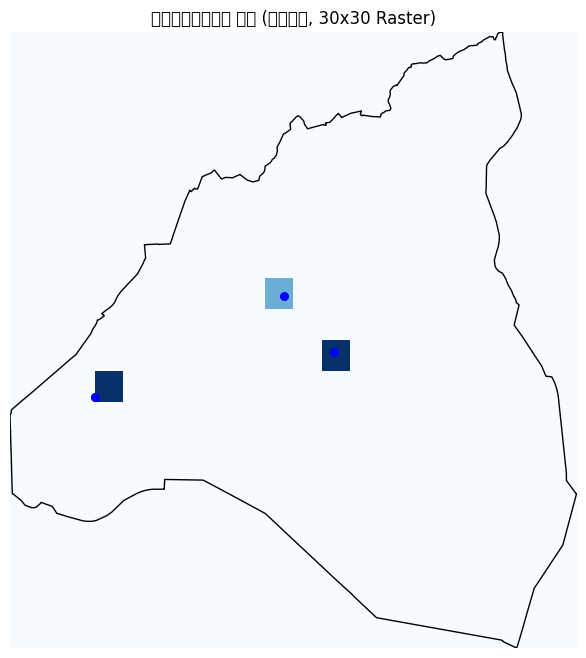

In [39]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# ✅ 동대문구 경계 고정 (이미 위에서 정의했으면 생략 가능)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)
dongdaemun4326 = dongdaemun.to_crs(epsg=4326)

# ✅ 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# ✅ GeoDataFrame 생성 및 동대문구 기준 클리핑
senior_gdf = gpd.GeoDataFrame(
    senior_leisure,
    geometry=gpd.points_from_xy(senior_leisure["경도"], senior_leisure["위도"]),
    crs="EPSG:4326"
)
senior_clipped = gpd.clip(senior_gdf, dongdaemun4326)
senior_proj = senior_clipped.to_crs(epsg=5186)

# ✅ 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# ✅ 포인트를 셀에 매핑 (누적 카운트)
for point in senior_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1  # 밀도 표현: 노인여가복지시설 개수만큼 증가

# ✅ .asc 파일로 저장
with rasterio.open(
    "senior_leisure.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: senior_leisure.asc (30x30 셀 기준)")

# ✅ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Blues', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
senior_proj.plot(ax=plt.gca(), color='blue', markersize=30)
plt.title("노인여가복지시설 분포 (동대문구, 30x30 Raster)")
plt.axis('off')
plt.show()


## senior_job

In [12]:
senior_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   시설명            1 non-null      object 
 1   시설코드           1 non-null      object 
 2   시설종류명(시설유형)    1 non-null      object 
 3   시설종류상세명(시설종류)  1 non-null      object 
 4   자치구(시)구분       1 non-null      object 
 5   시군구코드          1 non-null      int64  
 6   시군구명           1 non-null      object 
 7   시설주소           1 non-null      object 
 8   전화번호           0 non-null      float64
 9   우편번호           0 non-null      float64
 10  위도             1 non-null      float64
 11  경도             1 non-null      float64
dtypes: float64(4), int64(1), object(7)
memory usage: 228.0+ bytes


✅ 저장 완료: senior_job.asc (30x30 셀 기준)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages

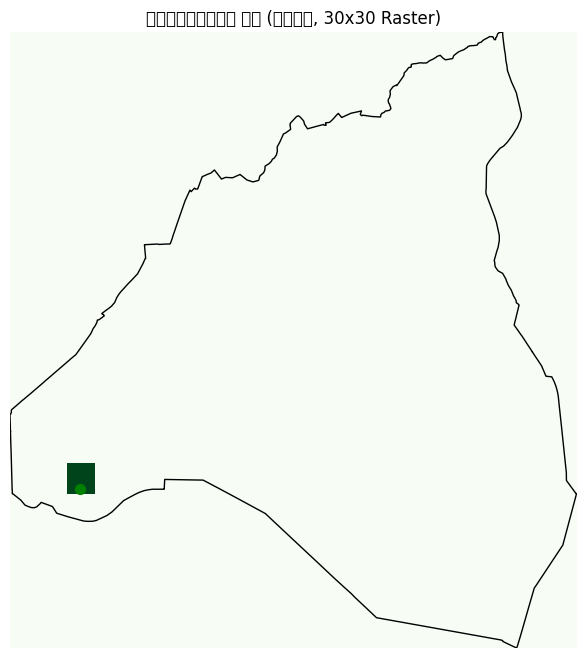

In [40]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 🧱 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 🧓 노인일자리 지원기관 GeoDataFrame 생성 및 클리핑
senior_job_gdf = gpd.GeoDataFrame(
    senior_job,
    geometry=gpd.points_from_xy(senior_job["경도"], senior_job["위도"]),
    crs="EPSG:4326"
)
senior_job_clipped = gpd.clip(senior_job_gdf, dongdaemun.to_crs(epsg=4326))
senior_job_proj = senior_job_clipped.to_crs(epsg=5186)

# 3. 🌐 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 4. 🔵 포인트 → 셀에 반영 (누적 카운트)
for point in senior_job_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1  # 누적 카운트: 각 격자에 있는 노인일자리 지원기관의 개수

# 5. 💾 저장
with rasterio.open(
    "senior_job.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: senior_job.asc (30x30 셀 기준)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Greens', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
senior_job_proj.plot(ax=plt.gca(), color='green', markersize=50)
plt.title("노인일자리지원시설 분포 (동대문구, 30x30 Raster)")
plt.axis('off')
plt.show()


## senior_homecare

In [14]:
senior_homecare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   시설명            83 non-null     object 
 1   시설코드           83 non-null     object 
 2   시설종류명(시설유형)    83 non-null     object 
 3   시설종류상세명(시설종류)  83 non-null     object 
 4   자치구(시)구분       83 non-null     object 
 5   시군구코드          83 non-null     int64  
 6   시군구명           83 non-null     object 
 7   시설주소           83 non-null     object 
 8   전화번호           0 non-null      float64
 9   우편번호           0 non-null      float64
 10  위도             80 non-null     float64
 11  경도             80 non-null     float64
dtypes: float64(4), int64(1), object(7)
memory usage: 7.9+ KB


✅ 저장 완료: senior_homecare.asc (30x30 셀 기준)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-package

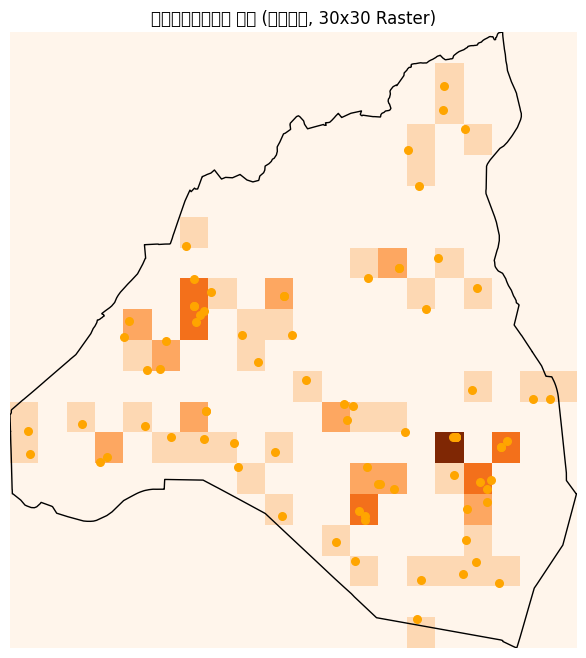

In [41]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 🧱 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 🧓 재가노인복지시설 GeoDataFrame 생성 및 클리핑
senior_homecare_clean = senior_homecare.dropna(subset=["위도", "경도"]).copy()
senior_homecare_gdf = gpd.GeoDataFrame(
    senior_homecare_clean,
    geometry=gpd.points_from_xy(senior_homecare_clean["경도"], senior_homecare_clean["위도"]),
    crs="EPSG:4326"
)
senior_homecare_clipped = gpd.clip(senior_homecare_gdf, dongdaemun.to_crs(epsg=4326))
senior_homecare_proj = senior_homecare_clipped.to_crs(epsg=5186)

# 3. 🌐 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 4. 🔵 포인트 → 셀에 반영 (누적 카운트)
for point in senior_homecare_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1  # 누적 카운트: 각 격자에 있는 재가노인복지시설의 개수

# 5. 💾 저장
with rasterio.open(
    "senior_homecare.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: senior_homecare.asc (30x30 셀 기준)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Oranges', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
senior_homecare_proj.plot(ax=plt.gca(), color='orange', markersize=30)
plt.title("재가노인복지시설 분포 (동대문구, 30x30 Raster)")
plt.axis('off')
plt.show()


## 노인 시설 하나로 통합

✅ 저장 완료: senior_facility.asc (노인시설 합산, 30x30 셀 기준)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-package

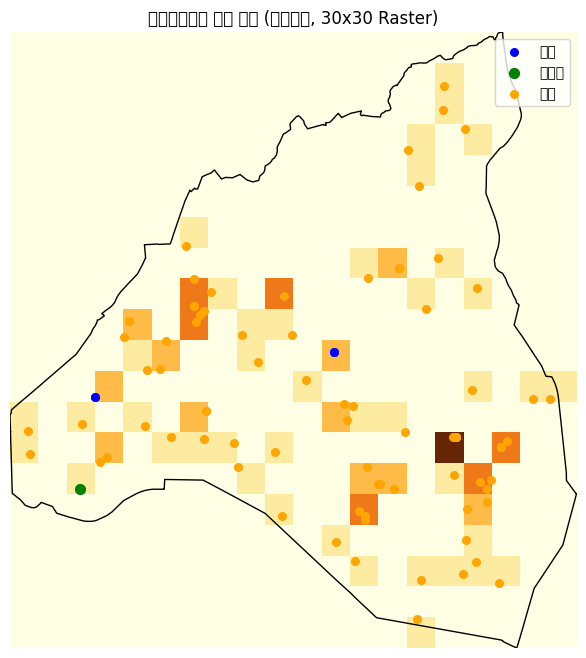

In [68]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 1. 📍 동대문구 경계 고정
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)
dongdaemun4326 = dongdaemun.to_crs(epsg=4326)

# 2. 🧱 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 3. 🧓 세 가지 노인시설 포인트 처리
def process_facility(df, color):
    df_clean = df.dropna(subset=["위도", "경도"]).copy()
    gdf = gpd.GeoDataFrame(
        df_clean,
        geometry=gpd.points_from_xy(df_clean["경도"], df_clean["위도"]),
        crs="EPSG:4326"
    )
    clipped = gpd.clip(gdf, dongdaemun4326)
    return clipped.to_crs(epsg=5186), color

senior_leisure_proj, leisure_color = process_facility(senior_leisure, 'blue')
senior_job_proj, job_color = process_facility(senior_job, 'green')
senior_homecare_proj, homecare_color = process_facility(senior_homecare, 'orange')

# 4. 🌐 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 5. 🔄 각 시설 포인트를 셀에 누적
def accumulate_points(proj_points):
    for point in proj_points.geometry:
        col = int((point.x - minx) / cell_width)
        row = int((maxy - point.y) / cell_height)
        if 0 <= row < height and 0 <= col < width:
            raster[row, col] += 1

accumulate_points(senior_leisure_proj)
accumulate_points(senior_job_proj)
accumulate_points(senior_homecare_proj)

# 6. 💾 .asc로 저장
with rasterio.open(
    "senior_facility.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: senior_facility.asc (노인시설 합산, 30x30 셀 기준)")

# 7. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='YlOrBr', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
senior_leisure_proj.plot(ax=plt.gca(), color=leisure_color, markersize=30, label='여가')
senior_job_proj.plot(ax=plt.gca(), color=job_color, markersize=50, label='일자리')
senior_homecare_proj.plot(ax=plt.gca(), color=homecare_color, markersize=30, label='돌봄')
plt.title("노인복지시설 분포 합산 (동대문구, 30x30 Raster)")
plt.axis('off')
plt.legend()
plt.show()


##  "cctv": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_CCTV.csv",

In [119]:
cctv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NO             2628 non-null   int64  
 1   ATNRG_NM       2628 non-null   object 
 2   SAFETY_ADDR    2628 non-null   object 
 3   CCTV_USE       2628 non-null   object 
 4   LA             2628 non-null   float64
 5   LO             2628 non-null   float64
 6   CCTV_QTY       2628 non-null   int64  
 7   UPDATE_DT      2628 non-null   object 
 8   PLCST_NM       2628 non-null   object 
 9   PLCST_DEPT_NM  2628 non-null   object 
 10  PLCST_DEPT_CD  2628 non-null   object 
 11  CTPR_PLAGC_NM  2628 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 246.5+ KB


In [120]:
cctv['CCTV_USE'].unique()

array(['방범', '어린이안전', '불법주정차', '도심공원', '쓰레기 무단투기', '치수방재', '미세먼지'],
      dtype=object)

In [80]:
cctv_car = cctv[cctv['CCTV_USE'].isin(['불법주정차'])]

In [81]:
cctv_child = cctv[cctv['CCTV_USE'].isin(['어린이안전'])]

In [83]:
cctv_child.info()
cctv_car.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 30 to 2612
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NO             383 non-null    int64  
 1   ATNRG_NM       383 non-null    object 
 2   SAFETY_ADDR    383 non-null    object 
 3   CCTV_USE       383 non-null    object 
 4   LA             383 non-null    float64
 5   LO             383 non-null    float64
 6   CCTV_QTY       383 non-null    int64  
 7   UPDATE_DT      383 non-null    object 
 8   PLCST_NM       383 non-null    object 
 9   PLCST_DEPT_NM  383 non-null    object 
 10  PLCST_DEPT_CD  383 non-null    object 
 11  CTPR_PLAGC_NM  383 non-null    object 
dtypes: float64(2), int64(2), object(8)
memory usage: 38.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 48 to 2545
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NO             150 non-n

## 어린이 안전 cctv

✅ 저장 완료: cctv_child.asc (30x30 셀 기준)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47536 (\N{HANGUL SYLLABLE RIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages

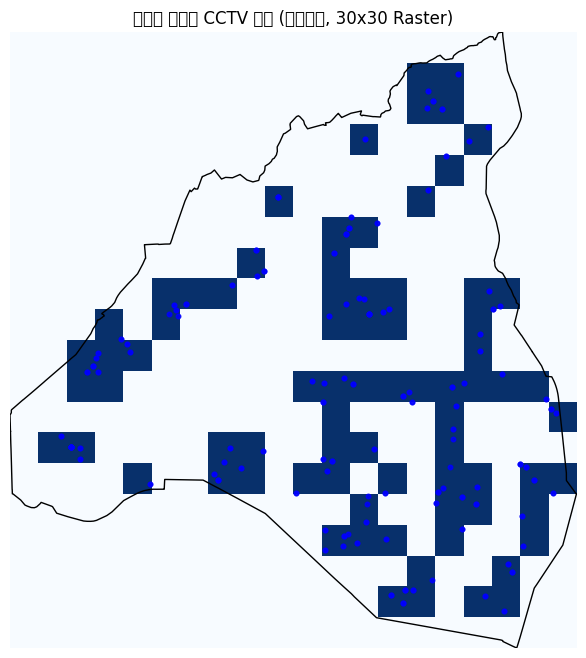

In [84]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 🧱 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 📂 CCTV_CHILD GeoDataFrame 생성 및 클리핑
cctv_child_clean = cctv_child.dropna(subset=["LA", "LO"]).copy()
cctv_child_gdf = gpd.GeoDataFrame(
    cctv_child_clean,
    geometry=gpd.points_from_xy(cctv_child_clean["LO"], cctv_child_clean["LA"]),
    crs="EPSG:4326"
)
cctv_child_clipped = gpd.clip(cctv_child_gdf, dongdaemun.to_crs(epsg=4326))
cctv_child_proj = cctv_child_clipped.to_crs(epsg=5186)

# 3. 🌐 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 4. 🔵 포인트 → 셀에 반영
for point in cctv_child_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] = 1  # 또는 += 1로 밀도 표현 가능

# 5. 💾 저장
with rasterio.open(
    "cctv_child.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: cctv_child.asc (30x30 셀 기준)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Blues', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
cctv_child_proj.plot(ax=plt.gca(), color='blue', markersize=10, alpha=0.6)
plt.title("어린이 보호용 CCTV 분포 (동대문구, 30x30 Raster)")
plt.axis('off')
plt.show()


## 불법주정차 cctv

✅ 저장 완료: cctv_car.asc (30x30 셀 기준)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pac

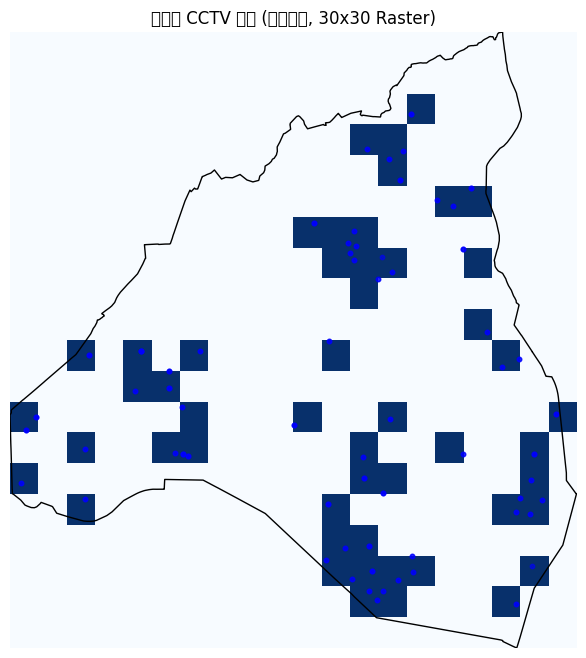

In [85]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 🧱 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 📂 CCTV_CAR GeoDataFrame 생성 및 클리핑
cctv_car_clean = cctv_car.dropna(subset=["LA", "LO"]).copy()
cctv_car_gdf = gpd.GeoDataFrame(
    cctv_car_clean,
    geometry=gpd.points_from_xy(cctv_car_clean["LO"], cctv_car_clean["LA"]),
    crs="EPSG:4326"
)
cctv_car_clipped = gpd.clip(cctv_car_gdf, dongdaemun.to_crs(epsg=4326))
cctv_car_proj = cctv_car_clipped.to_crs(epsg=5186)

# 3. 🌐 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 4. 🔵 포인트 → 셀에 반영
for point in cctv_car_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] = 1  # 또는 += 1로 밀도 표현 가능

# 5. 💾 저장
with rasterio.open(
    "cctv_car.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: cctv_car.asc (30x30 셀 기준)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Blues', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
cctv_car_proj.plot(ax=plt.gca(), color='blue', markersize=10, alpha=0.6)
plt.title("차량용 CCTV 분포 (동대문구, 30x30 Raster)")
plt.axis('off')
plt.show()


   ## 교차로

In [110]:
intersection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   교차로코드        285 non-null    int64  
 1   입력일자         0 non-null      float64
 2   교차로명칭        285 non-null    object 
 3   유형코드         285 non-null    int64  
 4   연동교차로코드      247 non-null    float64
 5   구코드 (공통);    285 non-null    float64
 6   지번           269 non-null    object 
 7   구경찰서 (공통);   284 non-null    float64
 8   신경찰서 (공통);   284 non-null    float64
 9   작업구분 (공통);   285 non-null    int64  
 10  표출구분 (공통);   285 non-null    int64  
 11  고객번호         0 non-null      float64
 12  계약종별         0 non-null      float64
 13  계량기번호        0 non-null      float64
 14  도로구분 (공통);   284 non-null    float64
 15  관할사업소 (공통);  284 non-null    float64
 16  교차로관리번호      285 non-null    object 
 17  공간데이터        0 non-null      float64
 18  신규정규화ID      192 non-null    float64
 19  이력ID    

In [ ]:
# 먼저, 유형코드를 교차로유형으로 매핑 (필요 시)
intersection['교차로유형'] = intersection['유형코드'].map({
    1: '단일로',
    2: '3거리',
    3: '4거리'
})

# 각 유형별로 분리
intersection_단일로 = intersection[intersection['교차로유형'] == '단일로']
intersection_3거리 = intersection[intersection['교차로유형'] == '3거리']
intersection_4거리 = intersection[intersection['교차로유형'] == '4거리']


✅ 저장 완료: intersection_single.asc (30x30 셀 기준)


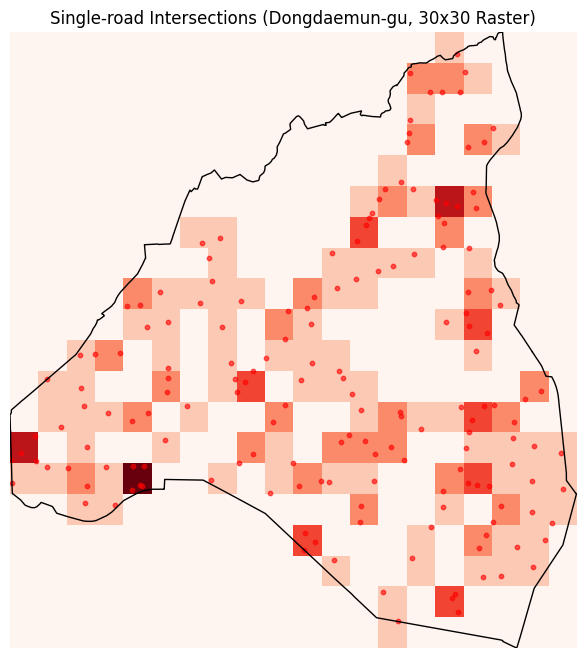

In [113]:
### 단일로

import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 🧱 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 📂 교차로 GeoDataFrame 생성 및 클리핑 (단일로만 사용)
intersection_clean = intersection_단일로.dropna(subset=["위도", "경도"]).copy()
intersection_gdf = gpd.GeoDataFrame(
    intersection_clean,
    geometry=gpd.points_from_xy(intersection_clean["경도"], intersection_clean["위도"]),
    crs="EPSG:4326"
)
intersection_clipped = gpd.clip(intersection_gdf, dongdaemun.to_crs(epsg=4326))
intersection_proj = intersection_clipped.to_crs(epsg=5186)

# 3. 🌐 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 4. 🔴 포인트 → 셀에 반영 (누적 카운트)
for point in intersection_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1

# 5. 💾 저장 (영문 이름)
with rasterio.open(
    "intersection_single.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: intersection_single.asc (30x30 셀 기준)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Reds', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
intersection_proj.plot(ax=plt.gca(), color='red', markersize=10, alpha=0.6)
plt.title("Single-road Intersections (Dongdaemun-gu, 30x30 Raster)")
plt.axis('off')
plt.show()



✅ 저장 완료: intersection_threeway.asc (30x30 셀 기준)


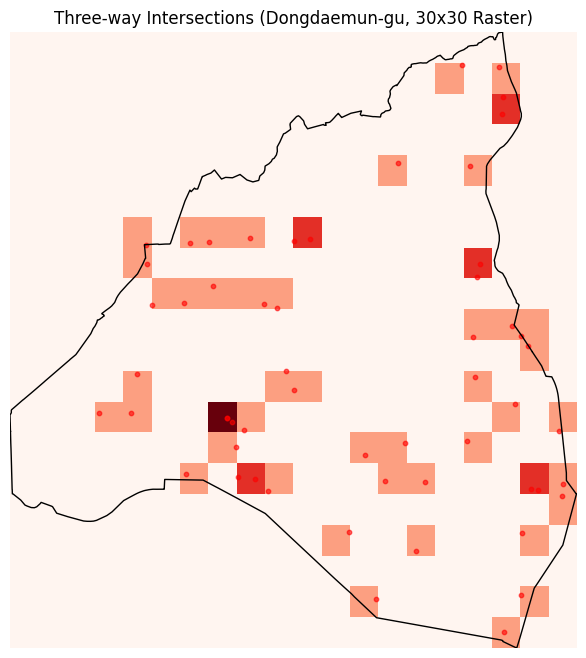

In [114]:
## 3거리
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 🧱 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 📂 교차로 GeoDataFrame 생성 및 클리핑 (3거리만 사용)
intersection_clean = intersection_3거리.dropna(subset=["위도", "경도"]).copy()
intersection_gdf = gpd.GeoDataFrame(
    intersection_clean,
    geometry=gpd.points_from_xy(intersection_clean["경도"], intersection_clean["위도"]),
    crs="EPSG:4326"
)
intersection_clipped = gpd.clip(intersection_gdf, dongdaemun.to_crs(epsg=4326))
intersection_proj = intersection_clipped.to_crs(epsg=5186)

# 3. 🌐 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 4. 🔴 포인트 → 셀에 반영 (누적 카운트)
for point in intersection_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1

# 5. 💾 저장 (영문 이름)
with rasterio.open(
    "intersection_threeway.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: intersection_threeway.asc (30x30 셀 기준)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Reds', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
intersection_proj.plot(ax=plt.gca(), color='red', markersize=10, alpha=0.6)
plt.title("Three-way Intersections (Dongdaemun-gu, 30x30 Raster)")
plt.axis('off')
plt.show()


✅ 저장 완료: intersection_fourway.asc (30x30 셀 기준)


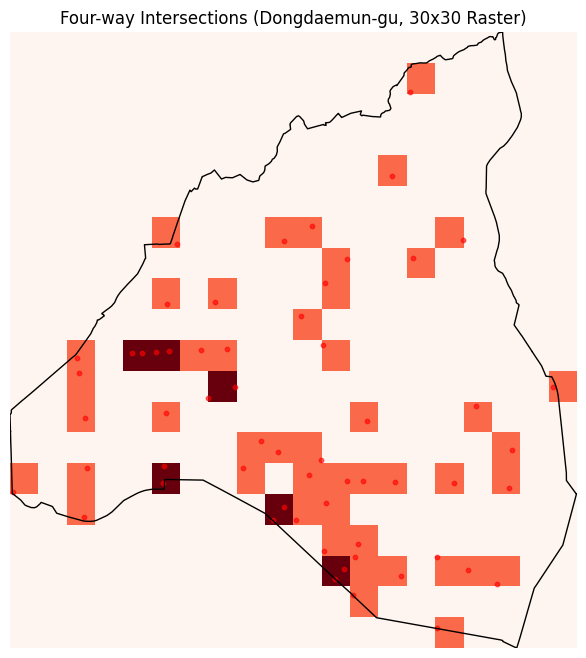

In [115]:
## 4거리
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 🧱 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 📂 교차로 GeoDataFrame 생성 및 클리핑 (4거리만 사용)
intersection_clean = intersection_4거리.dropna(subset=["위도", "경도"]).copy()
intersection_gdf = gpd.GeoDataFrame(
    intersection_clean,
    geometry=gpd.points_from_xy(intersection_clean["경도"], intersection_clean["위도"]),
    crs="EPSG:4326"
)
intersection_clipped = gpd.clip(intersection_gdf, dongdaemun.to_crs(epsg=4326))
intersection_proj = intersection_clipped.to_crs(epsg=5186)

# 3. 🌐 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 4. 🔴 포인트 → 셀에 반영 (누적 카운트)
for point in intersection_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1

# 5. 💾 저장 (영문 이름)
with rasterio.open(
    "intersection_fourway.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: intersection_fourway.asc (30x30 셀 기준)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Reds', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
intersection_proj.plot(ax=plt.gca(), color='red', markersize=10, alpha=0.6)
plt.title("Four-way Intersections (Dongdaemun-gu, 30x30 Raster)")
plt.axis('off')
plt.show()


 ##   "bus_stop": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_버스정류소.csv",
  

In [20]:
bus_stop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   노드 ID     316 non-null    int64  
 1   정류소번호     316 non-null    int64  
 2   정류소명      316 non-null    object 
 3   X좌표       316 non-null    float64
 4   Y좌표       316 non-null    float64
 5   정류소 타입    316 non-null    object 
 6   geometry  316 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 17.4+ KB


✅ 저장 완료: bus_stop.asc (30x30 셀 기준)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48260 (\N{HANGUL SYLLABLE BEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pac

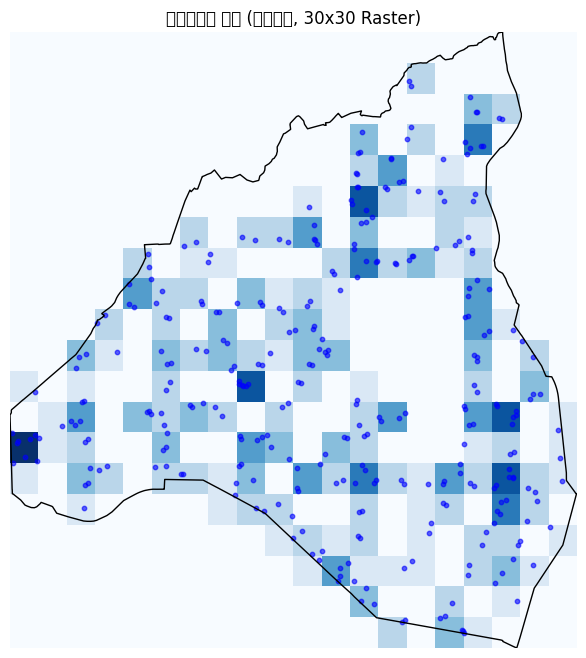

In [47]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 🧱 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 🚌 버스정류장 GeoDataFrame 생성 및 클리핑
bus_clean = bus_stop.dropna(subset=["Y좌표", "X좌표"]).copy()
bus_gdf = gpd.GeoDataFrame(
    bus_clean,
    geometry=gpd.points_from_xy(bus_clean["X좌표"], bus_clean["Y좌표"]),
    crs="EPSG:4326"
)
bus_clipped = gpd.clip(bus_gdf, dongdaemun.to_crs(epsg=4326))
bus_proj = bus_clipped.to_crs(epsg=5186)

# 3. 🌐 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 4. 🔵 포인트 → 셀에 반영 (누적 카운트로 밀도 표현)
for point in bus_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1  # 교차로가 여러 개 있을 때, 밀도 표현

# 5. 💾 저장
with rasterio.open(
    "bus_stop.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: bus_stop.asc (30x30 셀 기준)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Blues', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
bus_proj.plot(ax=plt.gca(), color='blue', markersize=10, alpha=0.6)
plt.title("버스정류장 분포 (동대문구, 30x30 Raster)")
plt.axis('off')
plt.show()


 ## "hospital": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_병의원.csv",


In [22]:
hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   주소      685 non-null    object 
 1   병원분류명   685 non-null    object 
 2   경도      685 non-null    float64
 3   위도      685 non-null    float64
dtypes: float64(2), object(2)
memory usage: 21.5+ KB


✅ 저장 완료: hospital_log.asc (로그 변환 적용)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48337 (\N{HANGUL SYLLABLE BYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pa

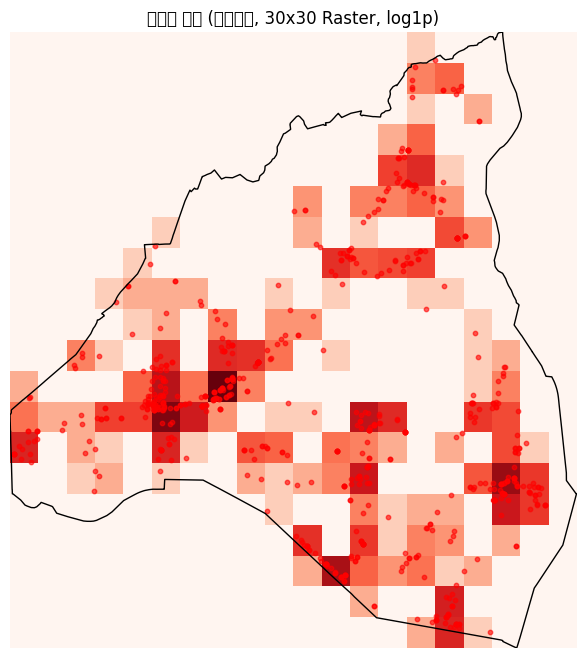

In [70]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 📐 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 🏥 병의원 GeoDataFrame 생성 및 클리핑
hospital_clean = hospital.dropna(subset=["위도", "경도"]).copy()
hospital_gdf = gpd.GeoDataFrame(
    hospital_clean,
    geometry=gpd.points_from_xy(hospital_clean["경도"], hospital_clean["위도"]),
    crs="EPSG:4326"
)
hospital_clipped = gpd.clip(hospital_gdf, dongdaemun.to_crs(epsg=4326))
hospital_proj = hospital_clipped.to_crs(epsg=5186)

# 3. 🌐 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint16)

# 4. 🔴 포인트 → 셀에 반영 (밀도 표현)
for point in hospital_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1  # 병의원이 여러 개 있을 때 밀도 표현

# ✅ 로그 변환 (log1p)
raster_log = np.log1p(raster).astype(np.float32)

# 5. 💾 저장 (.asc)
with rasterio.open(
    "hospital_log.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster_log.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster_log, 1)

print("✅ 저장 완료: hospital_log.asc (로그 변환 적용)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster_log, cmap='Reds', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
hospital_proj.plot(ax=plt.gca(), color='red', markersize=10, alpha=0.6)
plt.title("병의원 분포 (동대문구, 30x30 Raster, log1p)")
plt.axis('off')
plt.show()


 ##   "market": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_전통시장.csv",


In [49]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   아이디      20 non-null     object 
 1   상권명      20 non-null     object 
 2   시도명      20 non-null     object 
 3   시군구명     20 non-null     object 
 4   읍면동명     20 non-null     object 
 5   면적       20 non-null     float64
 6   업체수      20 non-null     float64
 7   위도       20 non-null     float64
 8   경도       20 non-null     float64
 9   데이터기준일자  20 non-null     object 
 10  이미지명     20 non-null     object 
dtypes: float64(4), object(7)
memory usage: 2.2+ KB


✅ 저장 완료: market_kde_density_log_weighted.asc (KDE 밀도 로그 변환, 가중치 부여)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pack

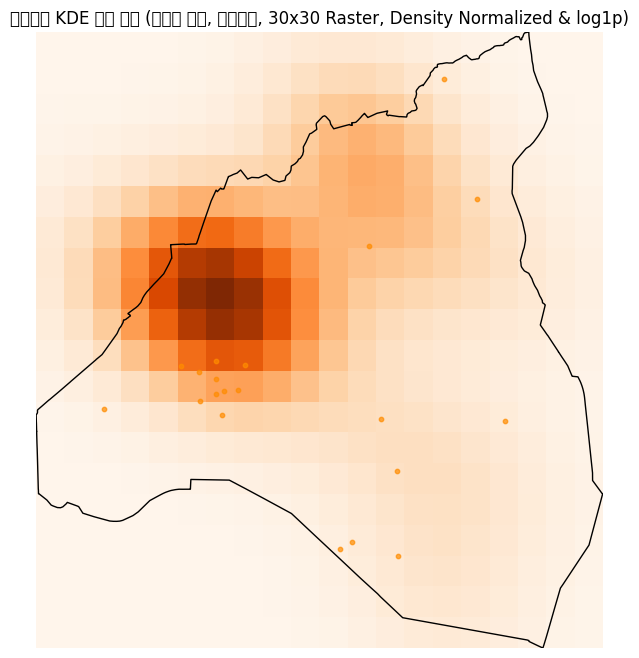

In [108]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 📐 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 🛒 전통시장 GeoDataFrame 생성 및 클리핑
market_clean = market.dropna(subset=["위도", "경도"]).copy()
market_gdf = gpd.GeoDataFrame(
    market_clean,
    geometry=gpd.points_from_xy(market_clean["경도"], market_clean["위도"]),
    crs="EPSG:4326"
)
market_clipped = gpd.clip(market_gdf, dongdaemun.to_crs(epsg=4326))
market_proj = market_clipped.to_crs(epsg=5186)

# 3. 🧱 포인트 좌표 추출
points = np.array([[point.x, point.y] for point in market_proj.geometry])

# 4. 🟠 KDE 계산 (가우시안 커널 밀도 추정)
kde = gaussian_kde(points.T, bw_method='silverman')  # bw_method는 대역폭 설정
x_grid, y_grid = np.meshgrid(np.linspace(minx, maxx, width), np.linspace(miny, maxy, height))
grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()])
density = kde(grid_points).reshape((height, width))

# 5. 📐 밀도 정규화 (셀 크기 기반)
density_normalized = density / (cell_width * cell_height)  # 밀도 계산 (셀 면적으로 나누기)

# ✅ 로그 변환 (log1p)
density_log = np.log1p(density_normalized).astype(np.float32)

# 6. 🛠️ 가중치 부여 (가중치 0.5 예시)
weight = 0.5  # 전통시장 밀도에 가중치 부여
density_weighted = density_log * weight

# 7. 💾 저장 (.asc)
with rasterio.open(
    "market_kde_density_log_weighted.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=density_weighted.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(density_weighted, 1)

print("✅ 저장 완료: market_kde_density_log_weighted.asc (KDE 밀도 로그 변환, 가중치 부여)")

# 8. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(density_weighted, cmap='Oranges', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
market_proj.plot(ax=plt.gca(), color='darkorange', markersize=10, alpha=0.7)
plt.title("전통시장 KDE 밀도 분포 (가중치 부여, 동대문구, 30x30 Raster, Density Normalized & log1p)")
plt.axis('off')
plt.show()


✅ 저장 완료: market_binary_mask_300m.asc (300m 내 영향력 이진 마스크)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pack

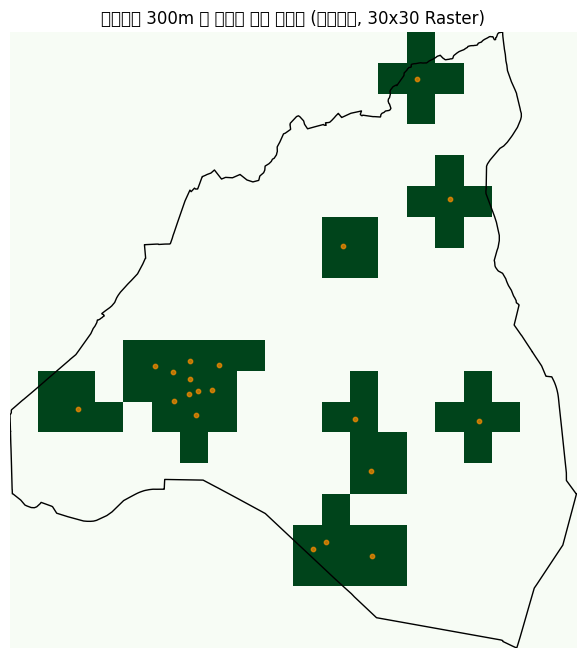

In [109]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 📐 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 🛒 전통시장 GeoDataFrame 생성 및 클리핑
market_clean = market.dropna(subset=["위도", "경도"]).copy()
market_gdf = gpd.GeoDataFrame(
    market_clean,
    geometry=gpd.points_from_xy(market_clean["경도"], market_clean["위도"]),
    crs="EPSG:4326"
)
market_clipped = gpd.clip(market_gdf, dongdaemun.to_crs(epsg=4326))
market_proj = market_clipped.to_crs(epsg=5186)

# 3. 🧱 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 4. 🟠 전통시장 근처 300m 이내 영향을 1로 설정 (이진 변수)
buffer_distance = 300  # 300m 이내 영향력
for point in market_proj.geometry:
    # 전통시장의 좌표를 셀 인덱스로 변환
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    
    # 전통시장 주변 300m 내의 셀을 1로 설정
    for r in range(height):
        for c in range(width):
            # 셀 중심 좌표 계산
            x_center = minx + c * cell_width + (cell_width / 2)
            y_center = maxy - r * cell_height - (cell_height / 2)
            # 셀과 전통시장 간의 거리 계산
            distance = np.sqrt((x_center - point.x) ** 2 + (y_center - point.y) ** 2)
            
            # 300m 이내의 셀에 영향력 1 부여
            if distance <= buffer_distance:
                raster[r, c] = 1

# 5. 💾 저장 (.asc)
with rasterio.open(
    "market_binary_mask_300m.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: market_binary_mask_300m.asc (300m 내 영향력 이진 마스크)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Greens', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
market_proj.plot(ax=plt.gca(), color='darkorange', markersize=10, alpha=0.7)
plt.title("전통시장 300m 내 영향력 이진 마스크 (동대문구, 30x30 Raster)")
plt.axis('off')
plt.show()


## "subway": r"C:\Users\윤홍식\Desktop\동대문구 공모전\데이터\동대문구_지하철역.csv",
 

In [26]:
subway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   연번            5 non-null      int64  
 1   호선            5 non-null      int64  
 2   고유역번호(외부역코드)  5 non-null      int64  
 3   역명            5 non-null      object 
 4   위도            5 non-null      float64
 5   경도            5 non-null      float64
 6   작성일자          5 non-null      object 
 7   geometry      5 non-null      object 
dtypes: float64(2), int64(3), object(3)
memory usage: 452.0+ bytes


✅ 저장 완료: subway.asc (30x30 셀 기준)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52384 (\N{HANGUL SYLLABLE CEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packag

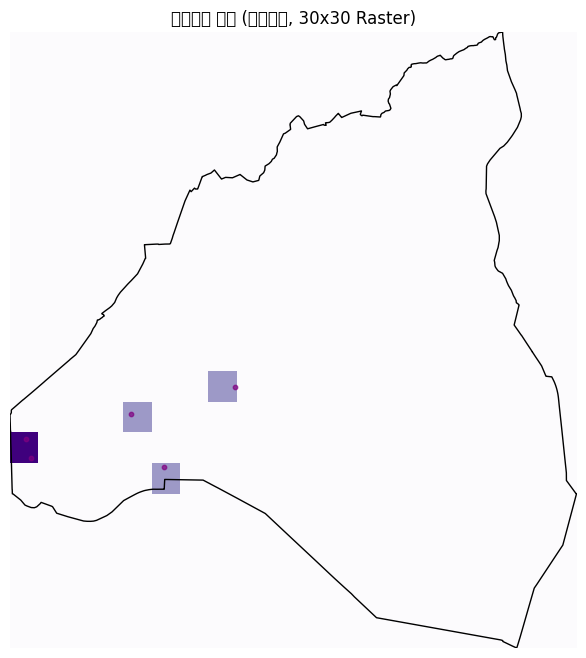

In [51]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 📐 고정 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 🚇 지하철 GeoDataFrame 생성 및 클리핑
subway_clean = subway.dropna(subset=["위도", "경도"]).copy()
subway_gdf = gpd.GeoDataFrame(
    subway_clean,
    geometry=gpd.points_from_xy(subway_clean["경도"], subway_clean["위도"]),
    crs="EPSG:4326"
)
subway_clipped = gpd.clip(subway_gdf, dongdaemun.to_crs(epsg=4326))
subway_proj = subway_clipped.to_crs(epsg=5186)

# 3. 🧱 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 4. 🟣 포인트 → 셀에 반영 (밀도 표현)
for point in subway_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1  # 지하철역이 여러 개 있을 때 밀도 표현

# 5. 💾 .asc 저장
with rasterio.open(
    "subway.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: subway.asc (30x30 셀 기준)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Purples', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
subway_proj.plot(ax=plt.gca(), color='purple', markersize=10, alpha=0.7)
plt.title("지하철역 분포 (동대문구, 30x30 Raster)")
plt.axis('off')
plt.show()


  ##  횡단보도



In [122]:
crosswalk = pd.read_csv("C:/Users/윤홍식/Desktop/동대문구 공모전/데이터/동대문구_횡단보도_중심좌표.csv")

In [123]:
print(crosswalk.head())


   횡단보도_ID 읍면동명         위도          경도
0    39625  장안동  37.567954  127.072554
1    43663  이문동  37.603148  127.062070
2    42606  제기동  37.582842  127.035719
3    50260  용두동  37.578050  127.038323
4    42994  장안동  37.566071  127.069466


✅ 저장 완료: crosswalk.asc (30x30 셀 기준)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pack

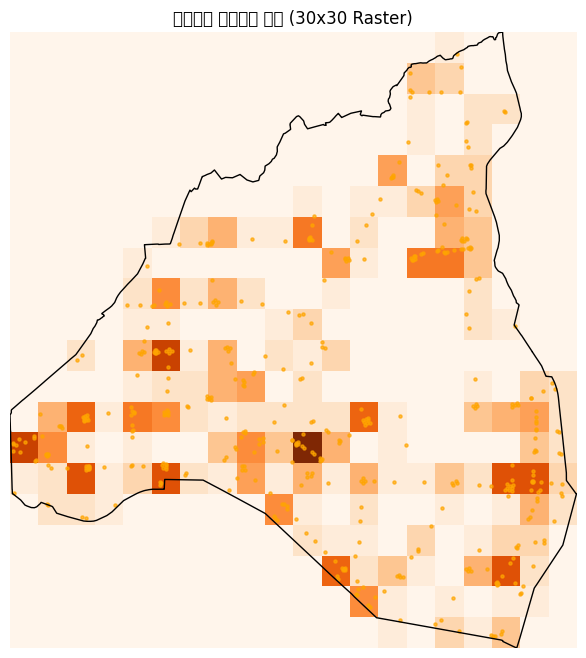

In [124]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# ✅ 0. 동대문구 경계 좌표계 고정 (EPSG:5186)
dongdaemun = dongdaemun.set_crs(epsg=5179, allow_override=True)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# ✅ 1. 고정된 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# ✅ 2. 횡단보도 데이터 GeoDataFrame 생성 및 클리핑
crosswalk_gdf = gpd.GeoDataFrame(
    crosswalk,
    geometry=gpd.points_from_xy(crosswalk["경도"], crosswalk["위도"]),
    crs="EPSG:4326"
)

dongdaemun_wgs84 = dongdaemun.to_crs(epsg=4326)
crosswalk_clipped = gpd.clip(crosswalk_gdf, dongdaemun_wgs84)
crosswalk_proj = crosswalk_clipped.to_crs(epsg=5186)

# ✅ 3. 빈 래스터 생성 후 포인트 찍기 (밀도 표현)
raster = np.zeros((height, width), dtype=np.uint8)

for point in crosswalk_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1  # 횡단보도가 여러 개 있을 경우 밀도 표현

# ✅ 4. ASC 파일로 저장
output_path = r"C:/Users/윤홍식/Desktop/동대문구 공모전/환경변수/crosswalk.asc"
with rasterio.open(
    output_path,
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: crosswalk.asc (30x30 셀 기준)")

# ✅ 5. 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Oranges', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
crosswalk_proj.plot(ax=plt.gca(), color='orange', markersize=5, alpha=0.7)
plt.title("동대문구 횡단보도 분포 (30x30 Raster)")
plt.axis('off')
plt.show()


## 노인장애인 보호구역 위치

In [27]:
area = pd.read_csv("C:/Users/윤홍식/Desktop/동대문구 공모전/데이터/서울특별시_동대문구_노인장애인보호구역_20240806.csv")

In [28]:
area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   장소유형코드    9 non-null      int64  
 1   대상시설명     9 non-null      object 
 2   시도명       9 non-null      object 
 3   시군구명      9 non-null      object 
 4   시군구코드     9 non-null      int64  
 5   소재지도로명주소  9 non-null      object 
 6   소재지지번주소   9 non-null      object 
 7   위도        9 non-null      float64
 8   경도        9 non-null      float64
 9   제한속도      9 non-null      int64  
 10  관리기관명     9 non-null      object 
 11  관리기관전화번호  9 non-null      object 
 12  관할경찰서명    9 non-null      object 
 13  CCTV설치여부  9 non-null      object 
 14  CCTV설치대수  9 non-null      int64  
 15  보호구역도로폭   9 non-null      int64  
 16  데이터기준일자   9 non-null      object 
dtypes: float64(2), int64(5), object(10)
memory usage: 1.3+ KB


✅ 저장 완료: silverzone.asc (30x30 셀 기준)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pack

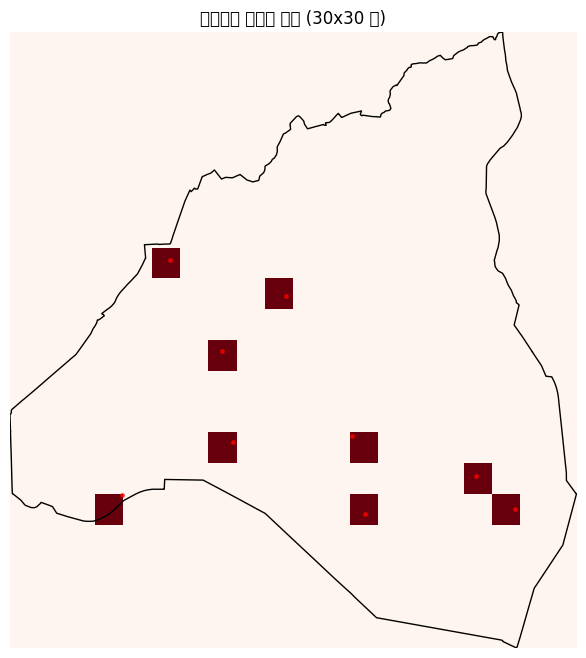

In [54]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# 0. 📍 동대문구 경계 고정 (EPSG:5186)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# 1. 📐 고정 30x30 셀 기준 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = num_cells
height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# 2. 🛑 실버존 좌표 기반 GeoDataFrame 생성 및 클리핑
area_clean = area.dropna(subset=["위도", "경도"]).copy()
area_gdf = gpd.GeoDataFrame(
    area_clean,
    geometry=gpd.points_from_xy(area_clean["경도"], area_clean["위도"]),
    crs="EPSG:4326"
)
area_clipped = gpd.clip(area_gdf, dongdaemun.to_crs(epsg=4326))
area_proj = area_clipped.to_crs(epsg=5186)

# 3. 🧱 빈 래스터 생성
raster = np.zeros((height, width), dtype=np.uint8)

# 4. 🔴 포인트 → 셀에 할당
for point in area_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] = 1

# 5. 💾 ASC 파일로 저장
with rasterio.open(
    "silverzone.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: silverzone.asc (30x30 셀 기준)")

# 6. 🖼️ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Reds', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
area_proj.plot(ax=plt.gca(), color='red', markersize=6, alpha=0.7)
plt.title("동대문구 실버존 위치 (30x30 셀)")
plt.axis('off')
plt.show()


## 동대문구 차량출입구 위치

In [30]:
car_out = pd.read_csv("C:/Users/윤홍식/Desktop/동대문구 공모전/데이터/동대문구_차량출입구.csv")

In [31]:
car_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시설명     64 non-null     object 
 1   위도      64 non-null     float64
 2   경도      64 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.6+ KB


✅ 저장 완료: car_out_density.asc (30x30 셀 기준 밀도 반영)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pack

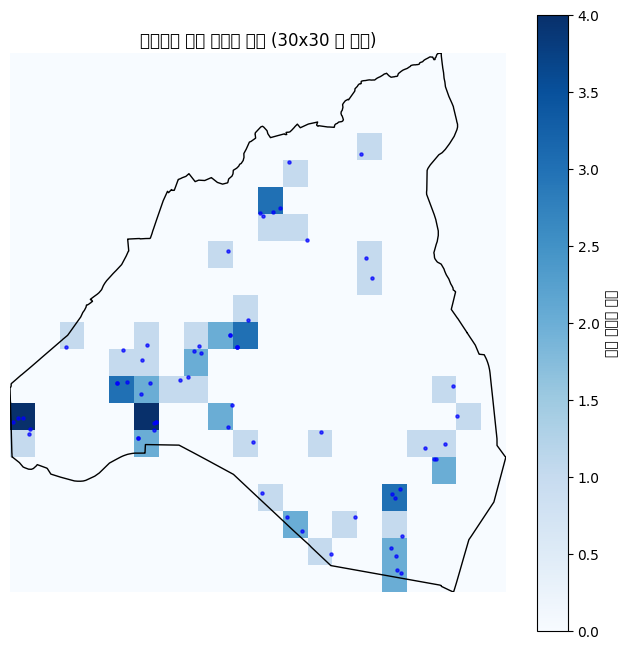

In [58]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# ✅ 0. 동대문구 경계 좌표계 고정 (EPSG:5186)
dongdaemun = dongdaemun.set_crs(epsg=5179, allow_override=True)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# ✅ 1. 30x30 셀 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# ✅ 2. 차량 출입구 좌표 기반 GeoDataFrame 생성
car_out_clean = car_out.dropna(subset=["경도", "위도"]).copy()
car_out_gdf = gpd.GeoDataFrame(
    car_out_clean,
    geometry=gpd.points_from_xy(car_out_clean["경도"], car_out_clean["위도"]),
    crs="EPSG:4326"
)

# ✅ 3. 동대문구 내 데이터만 클리핑 후 좌표계 변환
dongdaemun_wgs84 = dongdaemun.to_crs(epsg=4326)
car_out_clipped = gpd.clip(car_out_gdf, dongdaemun_wgs84)
car_out_proj = car_out_clipped.to_crs(epsg=5186)

# ✅ 4. 빈 래스터 생성 및 밀도 계산
raster = np.zeros((height, width), dtype=np.uint8)

for point in car_out_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1  # 각 셀에 포함된 포인트 수를 카운트

# ✅ 5. .asc 파일로 저장
with rasterio.open(
    "car_out_density.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: car_out_density.asc (30x30 셀 기준 밀도 반영)")

# ✅ 6. 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Blues', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
car_out_proj.plot(ax=plt.gca(), color='blue', markersize=5, alpha=0.7)
plt.title("동대문구 차량 출입구 밀도 (30x30 셀 기준)")
plt.axis('off')
plt.colorbar(label="차량 출입구 밀도")
plt.show()


## 무인교통단속 카메라 데이터 변환

In [63]:
cctv_way = pd.read_csv("C:/Users/윤홍식/Desktop/동대문구 공모전/데이터/서울특별시_동대문구_무인교통단속카메라_20240604.csv",encoding='euc-kr')
cctv_way.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   무인교통단속카메라관리번호  88 non-null     object 
 1   시도명            88 non-null     object 
 2   시군구명           88 non-null     object 
 3   도로종류           88 non-null     object 
 4   도로노선번호         0 non-null      float64
 5   도로노선명          88 non-null     object 
 6   도로노선방향         88 non-null     int64  
 7   소재지도로명주소       88 non-null     object 
 8   소재지지번주소        88 non-null     object 
 9   위도             88 non-null     float64
 10  경도             88 non-null     float64
 11  설치장소           88 non-null     object 
 12  단속구분           88 non-null     int64  
 13  제한속도           88 non-null     int64  
 14  단속구간위치구분       0 non-null      float64
 15  과속단속구간길이       0 non-null      float64
 16  보호구역구분         0 non-null      float64
 17  설치연도           88 non-null     int64  
 18  관리기관명       

✅ 저장 완료: cctv_way_density.asc (30x30 셀 기준 밀도 반영)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pack

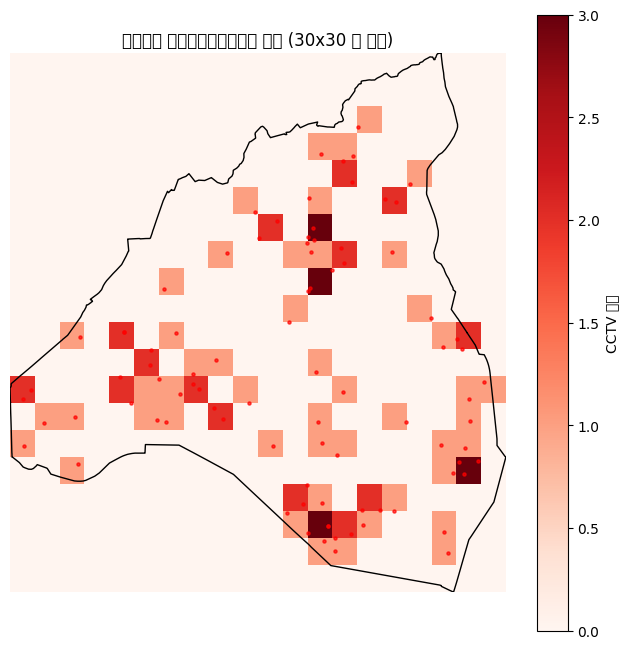

In [121]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# ✅ 0. 동대문구 경계 좌표계 고정 (EPSG:5186)
dongdaemun = dongdaemun.set_crs(epsg=5179, allow_override=True)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# ✅ 1. 30x30 셀 래스터 설정
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# ✅ 2. 좌표 기반 GeoDataFrame 생성 (cctv_way)
cctv_way_clean = cctv_way.dropna(subset=["경도", "위도"]).copy()
cctv_way_gdf = gpd.GeoDataFrame(
    cctv_way_clean,
    geometry=gpd.points_from_xy(cctv_way_clean["경도"], cctv_way_clean["위도"]),
    crs="EPSG:4326"
)

# ✅ 3. 동대문구 내 데이터만 클리핑 후 좌표계 변환
dongdaemun_wgs84 = dongdaemun.to_crs(epsg=4326)
cctv_way_clipped = gpd.clip(cctv_way_gdf, dongdaemun_wgs84)
cctv_way_proj = cctv_way_clipped.to_crs(epsg=5186)

# ✅ 4. 빈 래스터 생성 및 밀도 계산
raster = np.zeros((height, width), dtype=np.uint8)

for point in cctv_way_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] += 1  # 각 셀에 포함된 CCTV 수를 카운트

# ✅ 5. .asc 파일로 저장
with rasterio.open(
    "cctv_way_density.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: cctv_way_density.asc (30x30 셀 기준 밀도 반영)")

# ✅ 6. 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Reds', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
cctv_way_proj.plot(ax=plt.gca(), color='red', markersize=5, alpha=0.7)
plt.title("동대문구 무인교통단속카메라 밀도 (30x30 셀 기준)")
plt.axis('off')
plt.colorbar(label="CCTV 밀도")
plt.show()


## led바닥신호등 데이터

In [13]:
led = pd.read_csv("C:/Users/윤홍식/Desktop/동대문구 공모전/시각화용 데이터/서울특별시 동대문구_바닥신호등 현황_20240318.csv",encoding='euc-kr')
led.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   연번        44 non-null     int64  
 1   시설물위치명    44 non-null     object 
 2   소재지도로명주소  44 non-null     object 
 3   소재지지번주소   44 non-null     object 
 4   위도        44 non-null     float64
 5   경도        44 non-null     float64
 6   설치 연월     44 non-null     object 
 7   관리기관명     44 non-null     object 
 8   연락처       44 non-null     object 
 9   데이터기준일    44 non-null     object 
dtypes: float64(2), int64(1), object(7)
memory usage: 3.6+ KB


In [ ]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# ✅ 동대문구 경계 (EPSG:5186 기준)
dongdaemun = dongdaemun.set_crs(epsg=5179, allow_override=True)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# ✅ 래스터 셀 설정 (30x30)
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# ✅ led 좌표 기반 GeoDataFrame 생성
led_clean = led.dropna(subset=["경도", "위도"]).copy()
led_gdf = gpd.GeoDataFrame(
    led_clean,
    geometry=gpd.points_from_xy(led_clean["경도"], led_clean["위도"]),
    crs="EPSG:4326"
)

# ✅ 동대문구 내 데이터 클리핑 + 좌표계 변환
dongdaemun_wgs84 = dongdaemun.to_crs(epsg=4326)
led_clipped = gpd.clip(led_gdf, dongdaemun_wgs84)
led_proj = led_clipped.to_crs(epsg=5186)

# ✅ 빈 래스터에 포인트 찍기
raster = np.zeros((height, width), dtype=np.uint8)
for point in led_proj.geometry:
    col = int((point.x - minx) / cell_width)
    row = int((maxy - point.y) / cell_height)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] = 1

# ✅ .asc 저장
with rasterio.open(
    "led.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: led.asc (30x30 셀 기준)")

# ✅ 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Oranges', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
led_proj.plot(ax=plt.gca(), color='orange', markersize=5, alpha=0.7)
plt.title("동대문구 가로등 위치 (30x30 셀)")
plt.axis('off')
plt.show()


SyntaxError: invalid syntax (1855390846.py, line 44)

## 노인 인구 비율

In [104]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# ✅ 1. 동대문구 행정동 경계 데이터 읽기
shp_path = "C:/Users/윤홍식/Desktop/동대문구 공모전/데이터/BND_ADM_DONG_PG/BND_ADM_DONG_PG.shp"
gdf = gpd.read_file(shp_path)

# ✅ 2. 동 리스트 필터링
dong_list = [
    "회기동", "휘경1동", "휘경2동", "청량리동", "용신동",
    "제기동", "전농1동", "전농2동", "답십리2동", "장안1동",
    "장안2동", "이문1동", "이문2동", "답십리1동"
]
gdf_dongdaemun = gdf[gdf["ADM_NM"].isin(dong_list)].copy()

# ✅ 3. 좌표계 변환
gdf_dongdaemun = gdf_dongdaemun.to_crs(epsg=5186)

# ✅ 4. 고령인구 데이터 불러오기
pop_df = pd.read_csv("C:/Users/윤홍식/Documents/카카오톡 받은 파일/202412_202503_주민등록인구기타현황(고령 인구현황)_월간.csv", encoding='cp949')
pop_df = pop_df[['행정동', '전체 인구', '65세 이상 인구']].dropna()
pop_df['전체 인구'] = pop_df['전체 인구'].str.replace(',', '').astype(int)
pop_df['65세 이상 인구'] = pop_df['65세 이상 인구'].str.replace(',', '').astype(int)
pop_df['고령인구 비율'] = (pop_df['65세 이상 인구'] / pop_df['전체 인구']) * 100

# ✅ 5. 병합
gdf_dongdaemun = gdf_dongdaemun.merge(pop_df, left_on="ADM_NM", right_on="행정동", how="left")

gdf_dongdaemun.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BASE_DATE  14 non-null     object  
 1   ADM_CD     14 non-null     object  
 2   ADM_NM     14 non-null     object  
 3   geometry   14 non-null     geometry
 4   행정동        14 non-null     object  
 5   전체 인구      14 non-null     int32   
 6   65세 이상 인구  14 non-null     int32   
 7   고령인구 비율    14 non-null     float64 
dtypes: float64(1), geometry(1), int32(2), object(4)
memory usage: 916.0+ bytes


✅ 저장 완료: aged_population_ratio.asc (정규화된 고령인구 비율, 0~1 범위)


C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\윤홍식\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pack

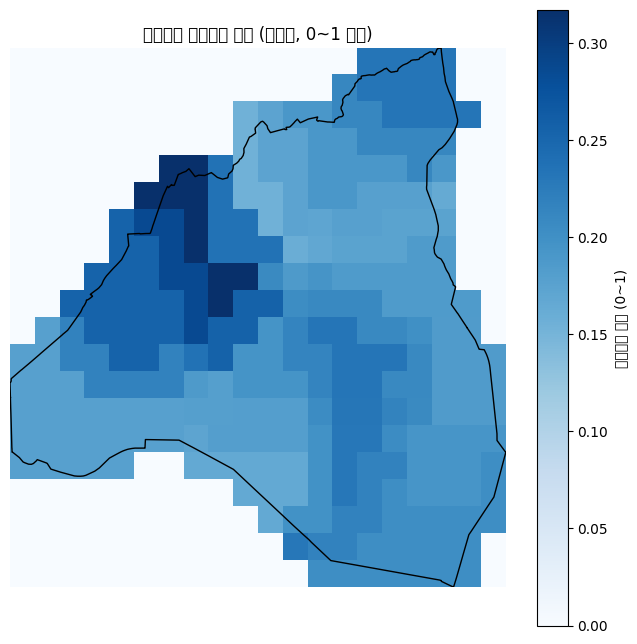

In [107]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from shapely.geometry import box

# ✅ 0. 동대문구 경계 좌표계 고정 (EPSG:5186)
dongdaemun = dongdaemun.set_crs(epsg=5179, allow_override=True)
dongdaemun_proj = dongdaemun.to_crs(epsg=5186)

# ✅ 1. 20x20 셀 래스터 설정 (CCTV와 동일하게)
num_cells = 20
minx, miny, maxx, maxy = dongdaemun_proj.total_bounds
width = height = num_cells
cell_width = (maxx - minx) / width
cell_height = (maxy - miny) / height
transform = from_origin(minx, maxy, cell_width, cell_height)

# ✅ 2. 동대문구 행정동 GeoDataFrame (gdf_dongdaemun은 이미 좌표계 EPSG:5186로 있음)

# ✅ 3. 빈 래스터 (float32 타입으로 비율 저장)
raster = np.zeros((height, width), dtype=np.float32)

# ✅ 4. 셀별로 고령인구 비율 계산 (정규화 포함)
for row in range(height):
    for col in range(width):
        x1 = minx + col * cell_width
        y1 = maxy - (row + 1) * cell_height
        x2 = x1 + cell_width
        y2 = y1 + cell_height
        cell_geom = box(x1, y1, x2, y2)
        
        # 해당 셀과 겹치는 행정동
        intersecting = gdf_dongdaemun[gdf_dongdaemun.geometry.intersects(cell_geom)]
        
        if not intersecting.empty:
            value = intersecting["고령인구 비율"].mean()
            raster[row, col] = value / 100.0  # 💡 0~1 정규화

# ✅ 5. NaN 제거
raster = np.nan_to_num(raster, nan=0.0).astype(np.float32)

# ✅ 6. .asc 파일 저장 (CCTV와 동일하게)
with rasterio.open(
    "aged_population_ratio.asc",
    'w',
    driver='AAIGrid',
    height=height,
    width=width,
    count=1,
    dtype='float32',
    crs='EPSG:5186',
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("✅ 저장 완료: aged_population_ratio.asc (정규화된 고령인구 비율, 0~1 범위)")

# ✅ 7. 시각화
plt.figure(figsize=(8, 8))
plt.imshow(raster, cmap='Blues', extent=(minx, maxx, miny, maxy), origin='upper')
dongdaemun_proj.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
plt.title("동대문구 고령인구 비율 (정규화, 0~1 범위)")
plt.axis('off')
plt.colorbar(label="고령인구 비율 (0~1)")
plt.show()


In [54]:
from pathlib import Path

base_path = Path(r"C:\Users\윤홍식\Desktop\동대문구 공모전\환경변수")

asc_files = list(base_path.glob("*.asc"))
for f in asc_files:
    print(f.name)


bus_stop.asc
car_out.asc
cctv.asc
hospital.asc
intersection.asc
market.asc
senior_homecare.asc
senior_job.asc
senior_leisure.asc
senior_pop.asc
senior_zone.asc
silverzone.asc
streetlight.asc
subway.asc


## 데이터 확인

In [102]:
import os
import rasterio
from rasterio.transform import from_origin
import numpy as np

# ✅ 기준 설정: 동대문구 좌표 범위 (기존 사용값)
minx, miny, maxx, maxy = 963428.6875, 1940035.625, 975128.6875, 1952455.625

# ✅ 고정 격자 해상도
num_cells = 30
cell_width = (maxx - minx) / num_cells
cell_height = (maxy - miny) / num_cells
expected_transform = from_origin(minx, maxy, cell_width, cell_height)
expected_shape = (num_cells, num_cells)
expected_crs = 'EPSG:5186'

# ✅ 폴더 경로 설정
folder_path = r"C:\Users\윤홍식\Desktop\동대문구 공모전\환경변수"

# ✅ 점검 시작
print("📋 MaxEnt 환경변수 체크리스트 검사 시작\n")

for filename in os.listdir(folder_path):
    if filename.endswith(".asc"):
        file_path = os.path.join(folder_path, filename)
        with rasterio.open(file_path) as src:
            print(f"🔍 {filename}")
            
            # 각 정보를 출력
            print(f"  ▶️ 좌표계 (CRS): {src.crs if src.crs is not None else '정보 없음'}")
            print(f"  ▶️ 변환 (transform): {src.transform}")
            print(f"  ▶️ 크기 (shape): {src.shape}")
            print(f"  ▶️ 데이터 타입 (dtype): {src.dtypes[0]}")
            print("-" * 40)

print("\n✅ 검사 완료. 위 항목들을 확인하여 MaxEnt 실행에 문제 없도록 설정하세요.")


📋 MaxEnt 환경변수 체크리스트 검사 시작

🔍 bus_stop.asc
  ▶️ 좌표계 (CRS): PROJCS["KGD2002 / Central Belt 2010",GEOGCS["GCS_KGD2002",DATUM["Korean_Geodetic_Datum_2002",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6737"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127],PARAMETER["scale_factor",1],PARAMETER["false_easting",200000],PARAMETER["false_northing",600000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  ▶️ 변환 (transform): | 243.33, 0.00, 202043.92|
| 0.00,-264.51, 556451.99|
| 0.00, 0.00, 1.00|
  ▶️ 크기 (shape): (20, 20)
  ▶️ 데이터 타입 (dtype): int32
----------------------------------------
🔍 car_out_density.asc
  ▶️ 좌표계 (CRS): PROJCS["KGD2002 / Central Belt 2010",GEOGCS["GCS_KGD2002",DATUM["Korean_Geodetic_Datum_2002",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6737"]

## asc 검사

In [83]:
import os
import rasterio
import numpy as np

def validate_asc_coverage(directory):
    print("📊 ASC 파일 커버리지 검사 시작...\n")

    for filename in os.listdir(directory):
        if filename.endswith(".asc"):
            path = os.path.join(directory, filename)
            try:
                with rasterio.open(path) as src:
                    data = src.read(1)
                    nodata = src.nodata

                    total = data.size
                    if nodata is not None:
                        nodata_count = np.sum(data == nodata)
                    else:
                        nodata_count = np.sum(np.isnan(data))  # 예외 처리

                    zero_count = np.sum(data == 0)

                    print(f"📁 {filename}")
                    print(f"  ▸ 총 셀 수: {total:,}")
                    print(f"  ▸ NoData 셀 수: {nodata_count:,} ({nodata_count/total:.2%})")
                    print(f"  ▸ 0 값 셀 수: {zero_count:,} ({zero_count/total:.2%})\n")
            except Exception as e:
                print(f"⚠️ {filename} 열기 실패: {e}\n")

# 경로 지정
asc_dir = r"C:\Users\윤홍식\Desktop\동대문구 공모전\환경변수"
validate_asc_coverage(asc_dir)


📊 ASC 파일 커버리지 검사 시작...

📁 bus_stop.asc
  ▸ 총 셀 수: 900
  ▸ NoData 셀 수: 0 (0.00%)
  ▸ 0 값 셀 수: 900 (100.00%)

📁 car_out.asc
  ▸ 총 셀 수: 900
  ▸ NoData 셀 수: 0 (0.00%)
  ▸ 0 값 셀 수: 900 (100.00%)

📁 cctv.asc
  ▸ 총 셀 수: 900
  ▸ NoData 셀 수: 0 (0.00%)
  ▸ 0 값 셀 수: 900 (100.00%)

📁 hospital.asc
  ▸ 총 셀 수: 900
  ▸ NoData 셀 수: 0 (0.00%)
  ▸ 0 값 셀 수: 900 (100.00%)

📁 intersection.asc
  ▸ 총 셀 수: 900
  ▸ NoData 셀 수: 0 (0.00%)
  ▸ 0 값 셀 수: 900 (100.00%)

📁 market.asc
  ▸ 총 셀 수: 900
  ▸ NoData 셀 수: 0 (0.00%)
  ▸ 0 값 셀 수: 900 (100.00%)

📁 senior_homecare.asc
  ▸ 총 셀 수: 900
  ▸ NoData 셀 수: 0 (0.00%)
  ▸ 0 값 셀 수: 900 (100.00%)

📁 senior_job.asc
  ▸ 총 셀 수: 900
  ▸ NoData 셀 수: 0 (0.00%)
  ▸ 0 값 셀 수: 900 (100.00%)

📁 senior_leisure.asc
  ▸ 총 셀 수: 900
  ▸ NoData 셀 수: 0 (0.00%)
  ▸ 0 값 셀 수: 900 (100.00%)

📁 silverzone.asc
  ▸ 총 셀 수: 900
  ▸ NoData 셀 수: 0 (0.00%)
  ▸ 0 값 셀 수: 900 (100.00%)

📁 streetlight.asc
  ▸ 총 셀 수: 900
  ▸ NoData 셀 수: 0 (0.00%)
  ▸ 0 값 셀 수: 900 (100.00%)

📁 subway.asc
  ▸ 총 셀 수: 900
  ▸ NoD